In [1]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding, Flatten, Dense
from keras.models import Sequential

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
from keras import models, layers, regularizers

Using TensorFlow backend.


In [2]:
data = pd.read_csv("Gillam_fin.csv").dropna()
data = data.drop("Unnamed: 0", axis = 1)
pd.DataFrame.head(data)

,id,transcript_id,gloss,part_of_speech,Impaired,Age,Gender
0,3772732,9573,and she asked um where do you wanna go,coord pro0sub v adv0int mod pro0per v v,1,10,0
1,3772777,9573,and the kids I guess answered Mcdonalds,coord det0art n v n0prop,1,10,0
2,3772812,9573,and so they went to Mcdonalds,coord co pro0sub v prep n0prop,1,10,0
3,3772852,9573,and Lisa couldn't make up her mind,coord n0prop mod v prep det0poss n,1,10,0
4,3772884,9573,and um she was deciding between a Big_Mac or a...,coord pro0sub aux part prep det0art n0prop coo...,1,10,0


In [3]:
# Split train, val, test
train, test = train_test_split(data, test_size=0.15, random_state=1234, shuffle = True)

# Process POS tags as X variable
str_train = list(train["part_of_speech"])
str_test = list(test["part_of_speech"])

Imp_train = train["Impaired"]
Imp_test = test["Impaired"]

Age_train = train["Age"]
Age_test = test["Age"]

In [6]:
# Vectorize tags
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(encoding = 'utf-8', ngram_range=(2,3), max_features=500)
X_train = vectorizer.fit_transform(str_train)
X_test = vectorizer.transform(str_test)
pos_vocab = vectorizer.vocabulary_

## Preparing model lists

In [100]:
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet

# Create a list of models
models = []
models_mse = []
models_auc = []

err_lst = ['neg_mean_squared_error', 'roc_auc']

def get_err(model, X, y):
    """
    Define a function that returns MSE and AUC
    """
    mse = np.mean(-cross_val_score(model, X, y, scoring=err_lst[0], cv = 5))
    auc = np.mean(cross_val_score(model, X, y, scoring=err_lst[1], cv = 5))
    return mse, auc

# Analysis 1: Impaired ~ POS vectors

In [129]:
## Logistic Regression
# Training
mse_lst = []
C_lst = np.arange(0.1, 1, 0.1)
for c in C_lst:
    LR = LogisticRegression(
        class_weight = {0: 3.380773819669337, 1: 1},
        solver = 'liblinear',
        penalty = 'l1',
        C = c)
    LR.fit(X_train, Imp_train)
    mse = np.mean(-cross_val_score(LR, X_train, Imp_train, cv=KFold(5), scoring=err_lst[0]))
    mse_lst.append(mse)
        
mse = min(mse_lst)
opt_C = C_lst[np.argmin(mse_lst)]
print("Best hyperparameter for Logistic Regression penalty is {}".format([{'C' : opt_C}]))

# Evaluation
LR_opt = LogisticRegression(
        solver = 'liblinear',
        penalty = 'l1',
        C = opt_C)
LR_opt.fit(X_train, Imp_train)
mse, auc = get_err(LR_opt, X_train, Imp_train)

print("MSE: {:.6f}".format(mse))
print("AUC: {:.6f}".format(auc))

models.append(LR_opt)
models_mse.append(mse)
models_auc.append(auc)

Best hyperparameter for Logistic Regression penalty is [{'C': 0.1}]
MSE: 0.230148
AUC: 0.597424


In [102]:
## Naive-Bayes
# Training
NB = GaussianNB()
NB.fit(X_train.toarray(), Imp_train)

# Evaluation
mse, auc = get_err(NB, X_train.toarray(), Imp_train)

print("MSE: {:.6f}".format(mse))
print("AUC: {:.6f}".format(auc))

models.append(NB)
models_mse.append(mse)
models_auc.append(auc)

MSE: 0.490751
AUC: 0.603546


In [103]:
## SVM Classifier
# Training
SVC = LinearSVC()
SVC.fit(X_train, Imp_train)

# Evaluation
mse, auc = get_err(SVC, X_train, Imp_train)

print("MSE: {:.6f}".format(mse))
print("AUC: {:.6f}".format(auc))

models.append(SVC)
models_mse.append(mse)
models_auc.append(auc)

MSE: 0.231199
AUC: 0.641011


In [108]:
## Ridge
# Tuning
alphas = np.arange(0,10,1)
mse_lst = []
for a in alphas:
    ridge = Ridge(alpha = a, solver = 'sag')
    ridge.fit(X_train, Imp_train)
    mse = np.mean(-cross_val_score(ridge, X_train, Imp_train, cv=KFold(5), scoring=err_lst[0]))
    mse_lst.append(mse)
        
mse = min(mse_lst)
opt_a = alphas[np.argmin(mse_lst)]
print("Best hyperparameter for Ridge penalty is {}".format([{'alpha' : opt_a}]))

# Evaluation
ridge_opt = Ridge(alpha = opt_a, solver = 'sag')
mse, auc = get_err(ridge_opt, X_train, Imp_train)

print("MSE: {:.6f}".format(mse))
print("AUC: {:.6f}".format(auc))

models.append(ridge_opt)
models_mse.append(mse)
models_auc.append(auc)

Best hyperparameter for Ridge penalty is [{'alpha': 9}]
MSE: 0.169282
AUC: 0.644114


In [105]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

## Random Forest

rf = RandomForestClassifier(
        n_estimators= 100,random_state= 1,
        criterion= 'gini',
        max_depth= 5,
        min_weight_fraction_leaf= 0,
        bootstrap= True)
rf.fit(X_train,Imp_train)
mse, auc = get_err(rf, X_train, Imp_train)
print("MSE: {:.6f}".format(mse))
print("AUC: {:.6f}".format(auc))

models.append(rf)
models_mse.append(mse)
models_auc.append(auc)

MSE: 0.230148
AUC: 0.621943


In [106]:
# Models Summary
models_col = ['Logistic Regression', 'Naive-Bayes', "LinearSVC",
              'Ridge', 'Random Forest']
models_report = pd.DataFrame([models_col, models_mse, models_auc]).T
models_report = models_report.rename({0 : "Models", 1 : "Error Rates", 2 : "AUC"}, axis = 1)
models_report = models_report.sort_values("Error Rates")

Text(0.5, 1.0, 'Error Rates for Models')

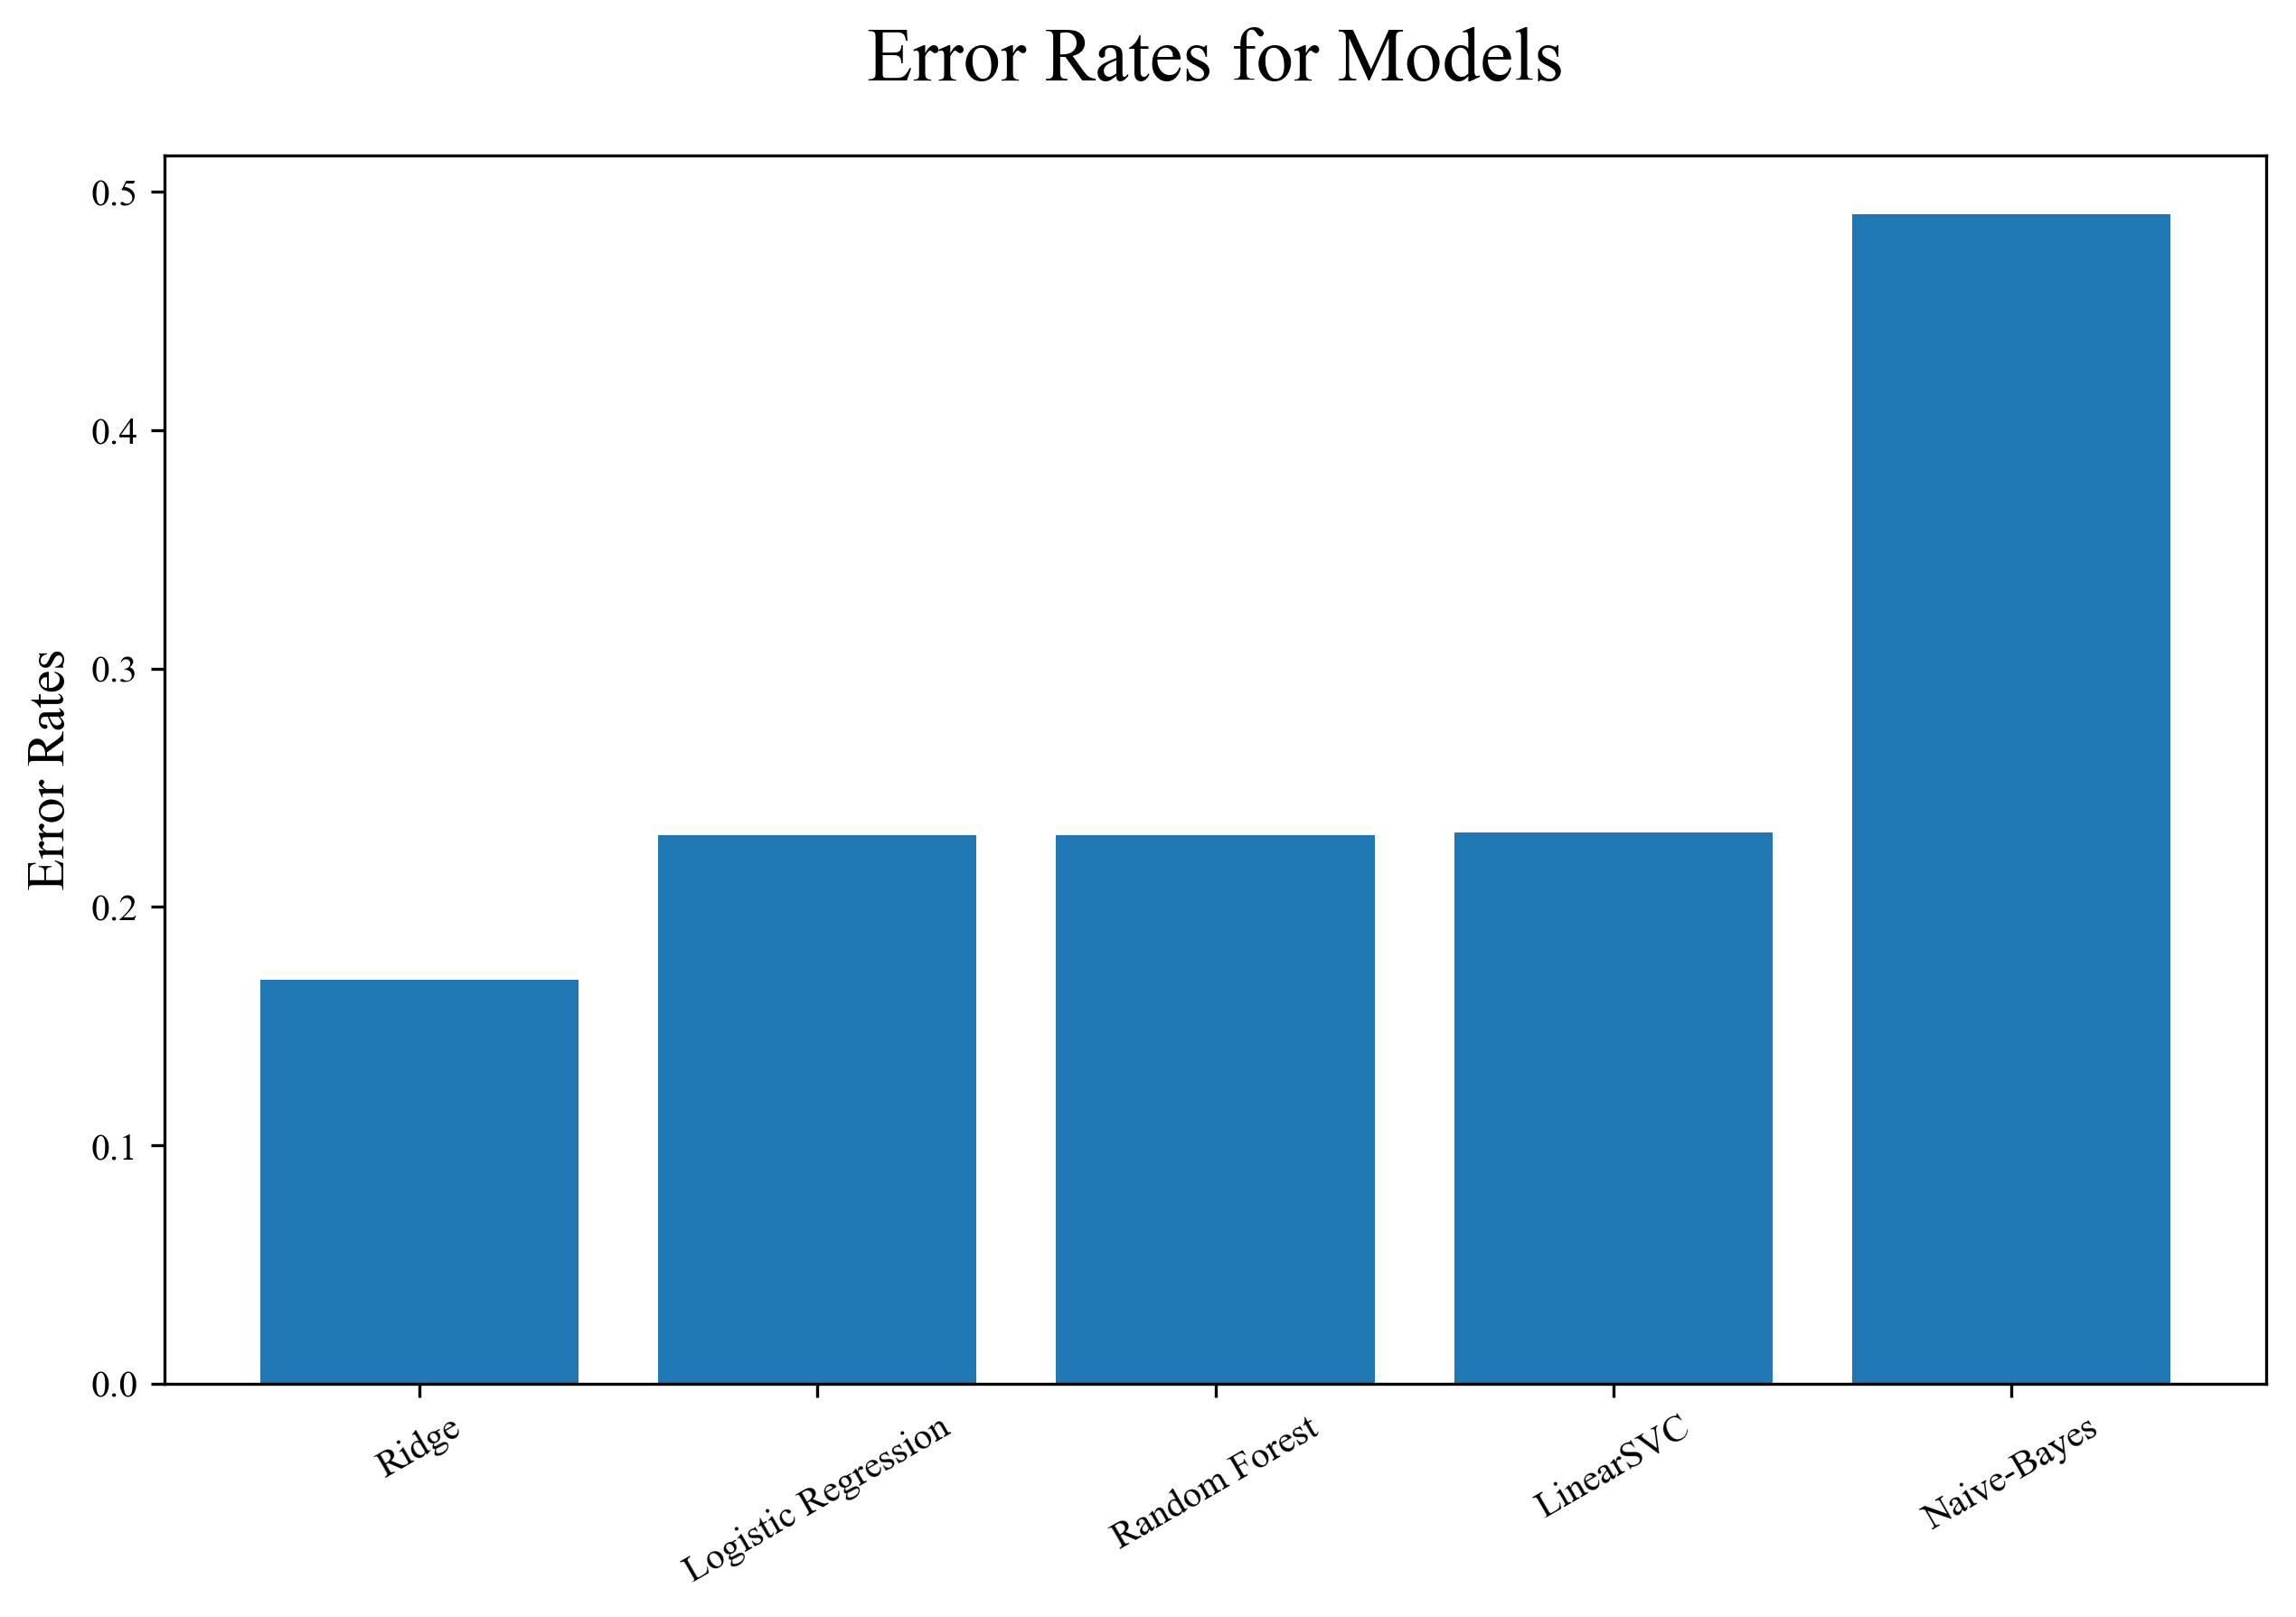

In [107]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['axes.titlepad'] = 20

plt.figure(figsize = (10,6), dpi = 300)
plt.bar(models_report["Models"], models_report["Error Rates"])
plt.xticks(rotation = 30)
plt.ylabel("Error Rates", fontsize = 14)
plt.title('Error Rates for Models', fontsize = 20)

In [15]:
from skater.model import InMemoryModel
from skater.core.explanations import Interpretation

best_model = models[3].fit(X_train, Imp_train)

# # calculate the feature importance
model = InMemoryModel(best_model.predict, examples = X_train.toarray())
interpreter = Interpretation(X_train.toarray())
importance = interpreter.feature_importance.feature_importance(model)

[500/500] features ████████████████████ Time elapsed: 440 seconds

In [32]:
feature_idx = list(importance.index)
features = []
for idx in feature_idx:
    features.append(list(pos_vocab.keys())[list(pos_vocab.values())[idx]])

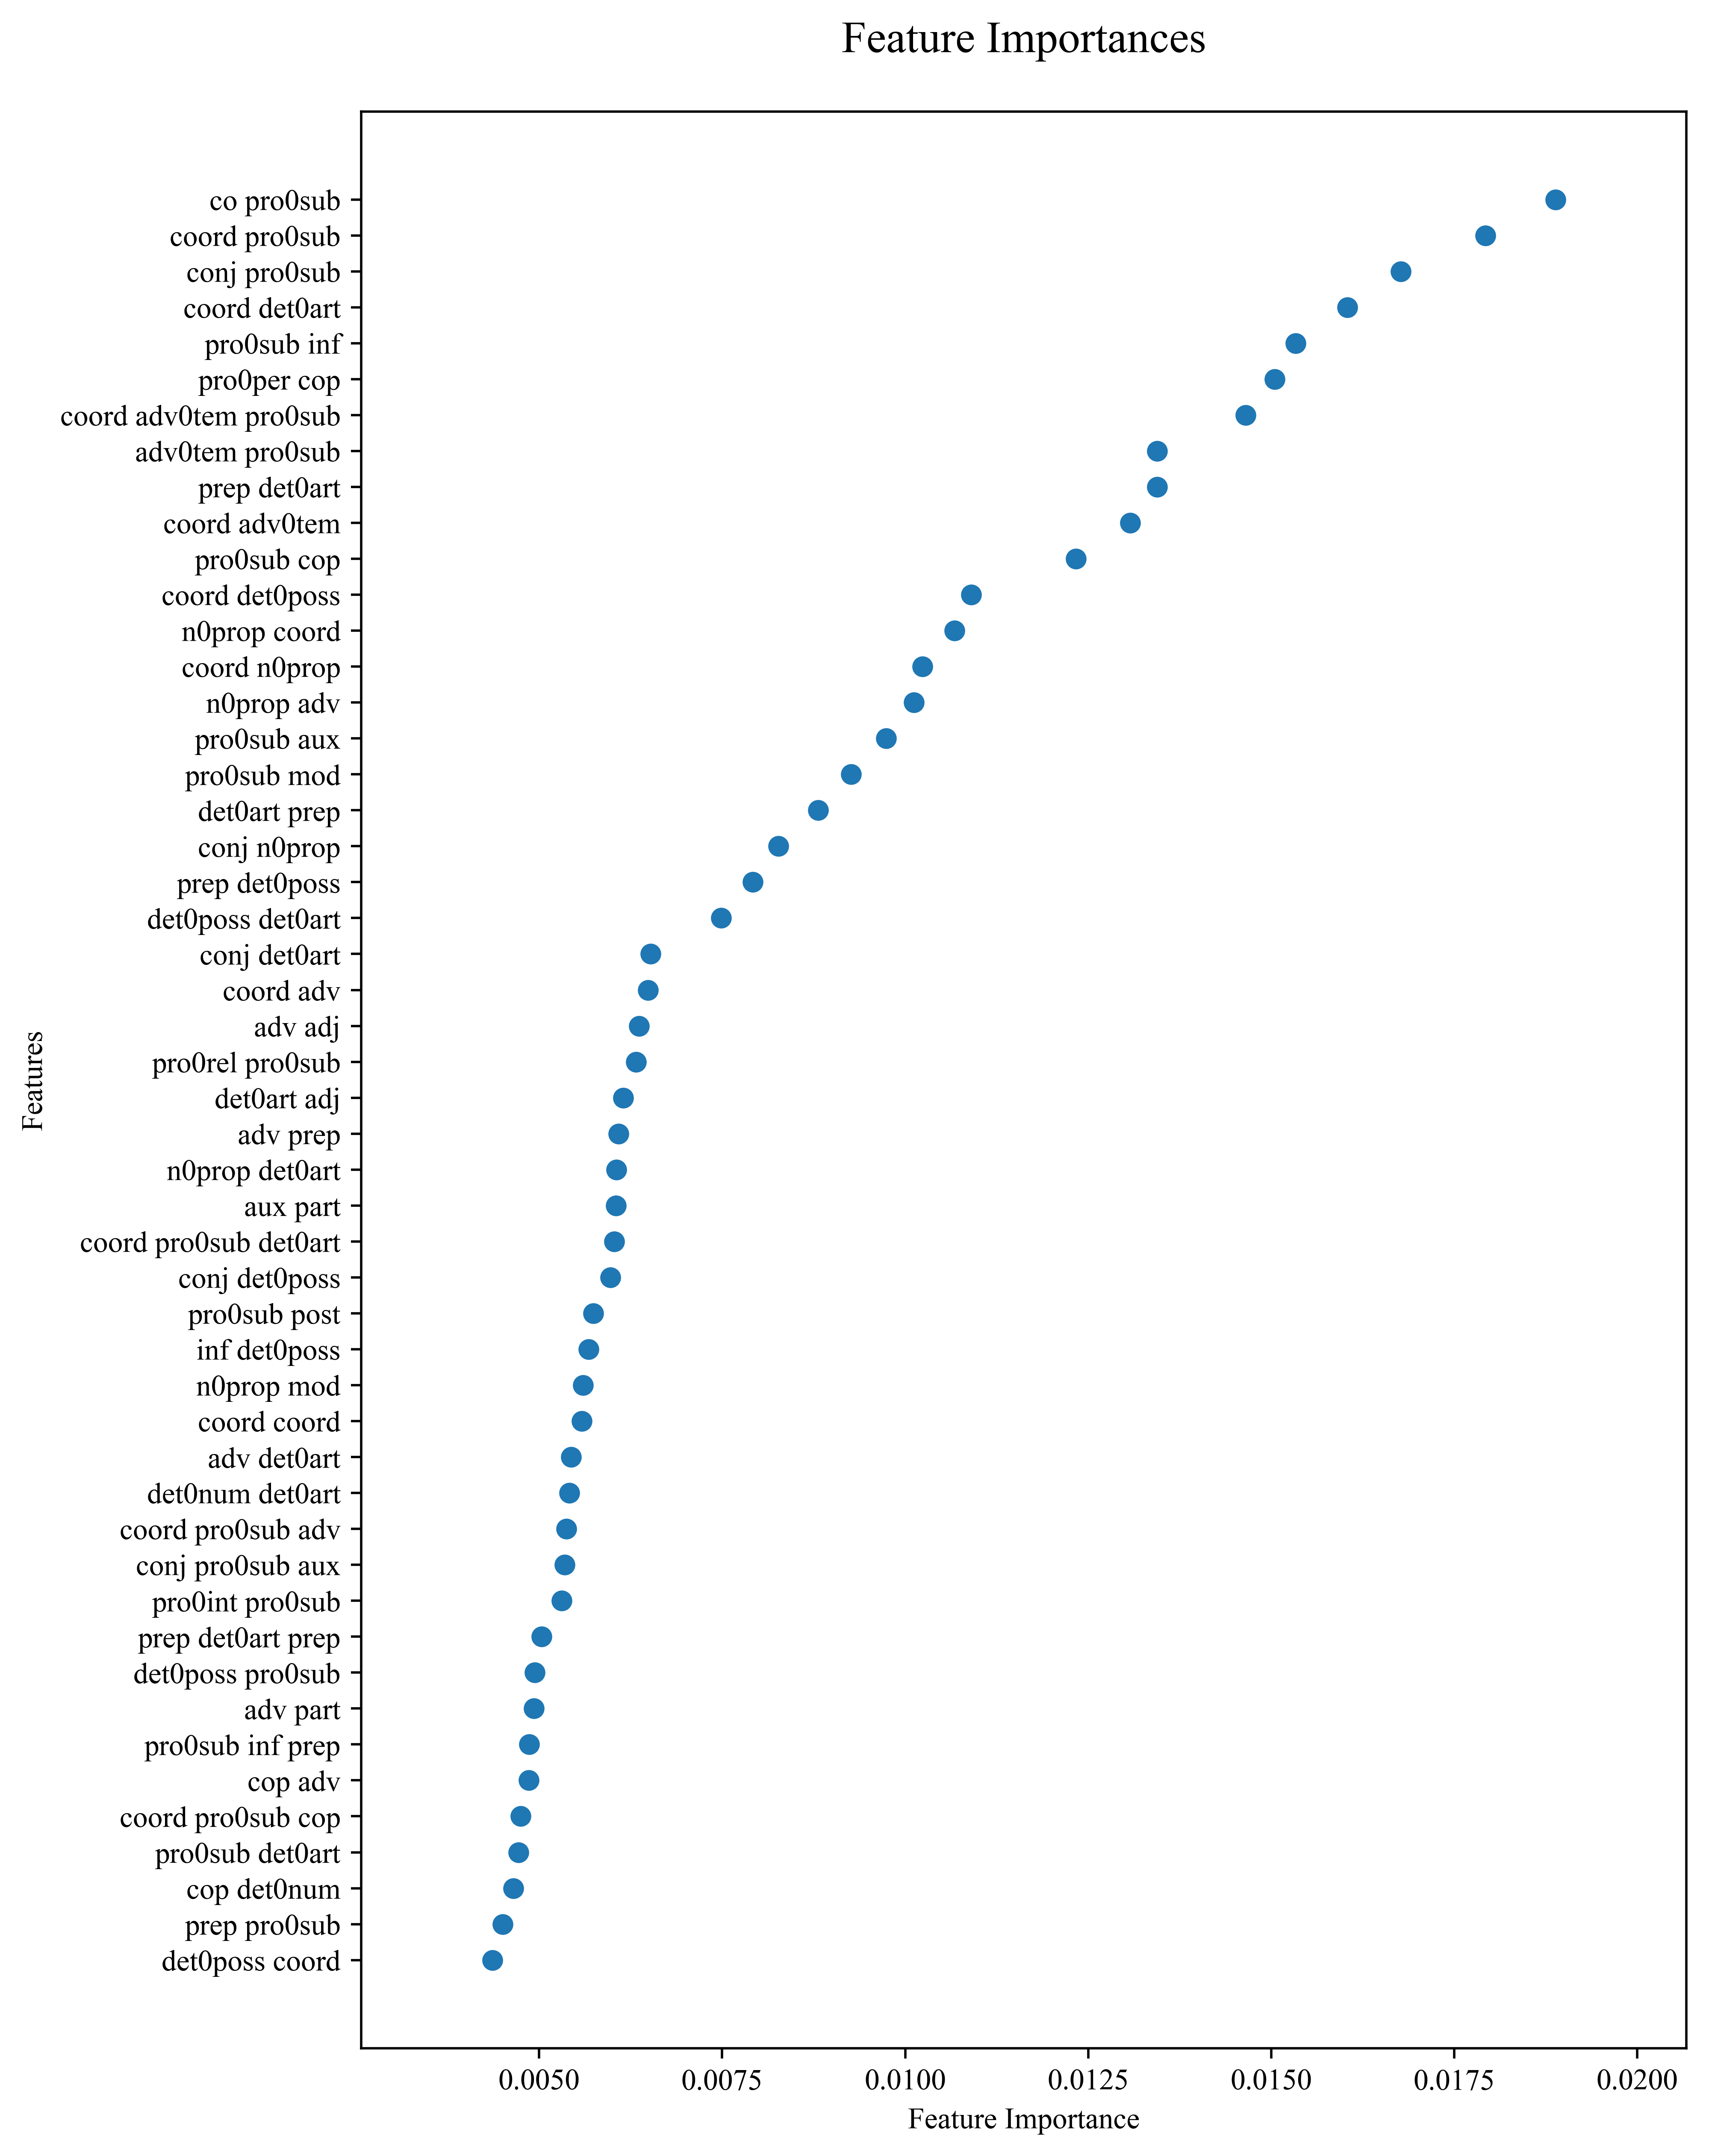

In [60]:
plt.figure(figsize=(8,12), dpi = 500)
plt.scatter(importance[-50:], np.arange(50))
plt.yticks(np.arange(50), features[-50:])
plt.title('Feature Importances', fontsize = 15)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
# plt.show()
plt.savefig('plot.png')

In [ ]:
from pycebox.ice import ice, ice_plot
# Because ridge has no attribute of predict_proba, I used LogisticRegression with penalty 'l2' (ridge Regression) instead. 
## In this case, penalty = 'l2', c = 1/alpha

ridge1 = LogisticRegression(C = 1/opt_a, penalty = 'l2', solver = 'sag')
ridge1 = ridge1.fit(X_train, Imp_train)
pred_func = lambda x: ridge1.predict_proba(x)[:,0]

X_train_df = pd.DataFrame(X_train.todense())
X_train_df

feat_idx = list(importance[-5:].keys())
for i in feat_idx:
    ice_df = ice(X_train_df, i, pred_func)
    ice_plot(ice_df, color='gray', linewidth=0.2, alpha=0.8, 
             centered = True, plot_pdp=True)
    _ = plt.title(list(pos_vocab.keys())[list(pos_vocab.values())[i]], fontsize = 15)

